# Install Dependencies

In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline

# Reddit: r/CMV example

**Post title:** 'CMV: It's normal and healthy to still love your ex, even while in a new relationship.'

**Post desc:** 'By the definition of my CMV, I'm ruling out any cases where the "love" borders more on obsession, or where the love gets in the way of the new relationship. This is really a push back against the idea that someone being in contact with their ex is a "red flag". In fact, I believe that still being in contact with an ex can actually be a green flag and can be indicative of a characteristic maturity that allows two adults, who used to be in a relationship, to still be friendly, despite how the relationship may have ended.

It's also important that I make the distinction between love and *in* love. If you're in love with one person, you should not be dating and telling another person you're in love with them - I think this is moving forward with a relationship when you're not emotionally available, and I think that can be incredibly damaging to the new partner. However, loving someone is very different - if you dated someone for years, or maybe even just months, and you developed a strong care for them and their well being, that won't just go away when you stop dating (except in certain more extreme circumstances).

Someone should be able to love their past partner in the sense that they care about them, they remain in contact to see how they're doing and they have a continuing relationship, even while pursuing serious relationships with others.

I'm curious what others think about this.'

**Top Comment 1:** 'If you love someone while you started a new relationship...you weren't ready for that new relationship.'

**Top Comment 2:** 'It's important to consider **why** they are your ex.

If you were dumped, then trying to keep in touch means you haven't moved on and it's a red flag.

If dumped them, it means you are stringing ex along and are being manipulative and it's a red flag.'

**Top Comment 3:** 'I agree with what you're trying to say but the title should have been caring not loving.¬†


You know what the correct word choice is based on your explanation, you know what the possibile connotations are, you've recognized that love is easy to confuse with in love given the context yet you still went with love instead of care...why?'

In [2]:
cmv_df = pd.read_csv('cmv_clean.csv')
# Max emotions represents the total emotions generated for each comment (ie our max)
# Min emotions represents the minimum number of emotions we accept for each comment (threshold)
max_emotions = 6
min_emotions = 3
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=max_emotions)

test_comment_1 = cmv_df.iloc[0]['Comment 1']
test_comment_2 = cmv_df.iloc[0]['Comment 2']
test_comment_3 = cmv_df.iloc[0]['Comment 3']

sentences = [test_comment_1, test_comment_2, test_comment_3]

print("Initial 3 labels")
for sentence in sentences:
  output = classifier(sentence)
  print(output)

print("")
print("Filtered 3 labels")

# Builds a list of labels to filter out
labels_to_exclude = ['neutral', 'approval']

for sentence in sentences:
    output = classifier(sentence)
    filtered_labels = []
    num_labels = 0

    # Check predictions and filter out labels that are found in the labels_to_exclude
    for prediction in output:
        filtered_predictions = [label for label in prediction if label['label'] not in labels_to_exclude]
        # Check to see if we still need to add more emotions to reach the minimum threshold for classification
        if (num_labels < min_emotions):
          # If we have not reached the min threshold, keep adding emotions
          filtered_labels.append(filtered_predictions)
          num_labels += 1

    print(filtered_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Initial 3 labels
[[{'label': 'neutral', 'score': 0.8108237385749817}, {'label': 'disapproval', 'score': 0.07914378494024277}, {'label': 'realization', 'score': 0.042752716690301895}, {'label': 'disappointment', 'score': 0.021041154861450195}, {'label': 'approval', 'score': 0.01977657899260521}, {'label': 'annoyance', 'score': 0.013485239818692207}]]
[[{'label': 'neutral', 'score': 0.7131112217903137}, {'label': 'approval', 'score': 0.11251146346330643}, {'label': 'realization', 'score': 0.06800545752048492}, {'label': 'disapproval', 'score': 0.05483492463827133}, {'label': 'annoyance', 'score': 0.04381724074482918}, {'label': 'caring', 'score': 0.03657557815313339}]]
[[{'label': 'approval', 'score': 0.8526751399040222}, {'label': 'curiosity', 'score': 0.12071607261896133}, {'label': 'neutral', 'score': 0.10230104625225067}, {'label': 'love', 'score': 0.04765845835208893}, {'label': 'realization', 'score': 0.030413122847676277}, {'label': 'confusion', 'score': 0.026881391182541847}]]

F

# Aggregating Emotions

In [4]:
import pandas as pd
from transformers import pipeline

cmv_df = pd.read_csv('cmv_clean.csv')

# Initialize the text classification pipeline found from this link below:
# https://huggingface.co/SamLowe/roberta-base-go_emotions
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

# Create a new map to store emotion frequencies
emotion_frequency = {}

# Initialize counter and total_count to keep track of progress while progressing through batches
counter = 0
total_count = len(cmv_df)

for index, row in cmv_df.iterrows():
    batch_comments = []

    # Collect comments for batch processing
    for i in range(1, 6):
        comment = row[f'Comment {i}']
        # Ensure comment is not NaN and less than the max tokens necessitated by model
        if isinstance(comment, str) and len(comment) < 512:
            batch_comments.append(comment)

    # Process comments in batches
    if len(batch_comments) > 0:
        outputs = classifier(batch_comments)

        for output in outputs:
            # Grab emotion labels for each output
            emotion_labels = [label['label'] for label in output]
            for emotion_label in emotion_labels:
              # Initialize the emotion to have frequency 1 if not found
              if emotion_label not in emotion_frequency:
                  emotion_frequency[emotion_label] = 1
              else:
                  # Otherwise increase the current value
                  emotion_frequency[emotion_label] += 1

    # Print out progress every 200 batches
    if (counter > 0 and counter % 200 == 0):
        print(f"Current count is: {counter} / {total_count}")
        print("Emotion Frequencies:")
        for emotion, count in emotion_frequency.items():
            print(f"{emotion}: {count}")
        print("")

    counter += 1

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency.items():
    print(f"{emotion}: {count}")


Current count is: 200 / 844
Emotion Frequencies:
neutral: 480
disapproval: 299
realization: 233
disappointment: 99
approval: 362
annoyance: 301
curiosity: 192
love: 9
confusion: 223
anger: 33
disgust: 11
amusement: 13
embarrassment: 2
optimism: 61
admiration: 26
excitement: 6
sadness: 31
joy: 10
surprise: 13
desire: 9
remorse: 4
fear: 6
nervousness: 2
caring: 13
relief: 2

Current count is: 400 / 844
Emotion Frequencies:
neutral: 937
disapproval: 570
realization: 443
disappointment: 186
approval: 711
annoyance: 586
curiosity: 374
love: 12
confusion: 429
anger: 70
disgust: 19
amusement: 22
embarrassment: 2
optimism: 130
admiration: 81
excitement: 12
sadness: 52
joy: 21
surprise: 20
desire: 16
remorse: 6
fear: 18
nervousness: 7
caring: 33
relief: 2
pride: 1
gratitude: 4
grief: 1

Current count is: 600 / 844
Emotion Frequencies:
neutral: 1423
disapproval: 854
realization: 669
disappointment: 265
approval: 1091
annoyance: 884
curiosity: 594
love: 16
confusion: 681
anger: 92
disgust: 30
amu

# Visualize Emotions on r/CMV

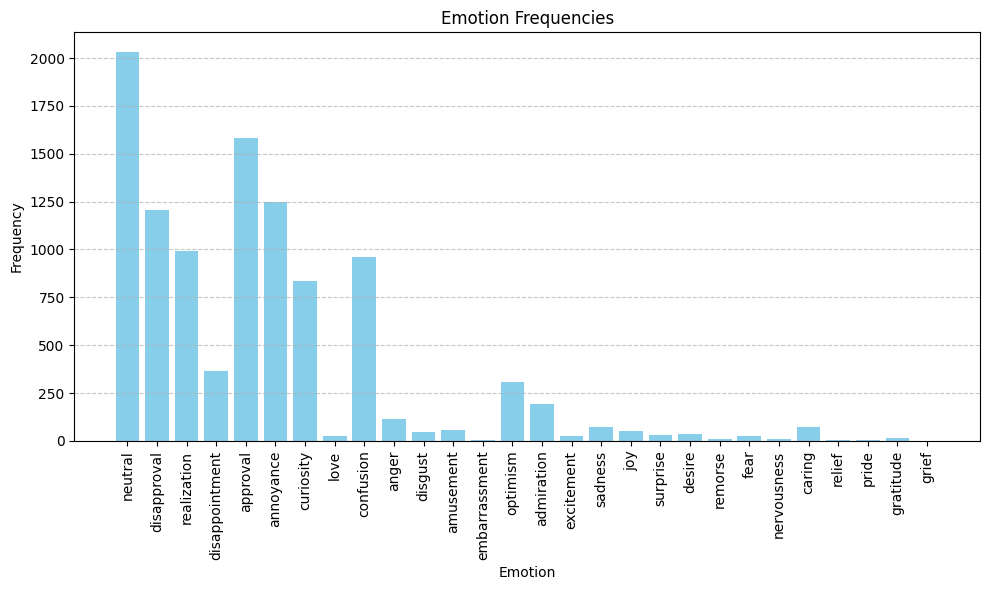

In [8]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency.keys())
frequencies = list(emotion_frequency.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

# Emotions Analysis:

**Neutral Emotion Possibly Overrepresented**
Because understanding the complexity of these responses can be difficult, this is likely the reason that the 'neutral' emotion has such high frequency, and is possibly overrepresented given the actual range of emotions on r/CMV.

**Approval / Disapproval Emotions Common**
Due to the nature of binary discourse on r/CMV, people are generally either for or against a controversial discussion topic, and sometimes will even explicitly state 'I agree' or 'I disagree' in their comment.

**Logical Reasoning and Realization** On r/CMV, it is common to explain and think through the logic of an argument or perspective on a topic. This likely leads to the 'realization' emotion being significantly higher than the other emotions not mentioned above (ie compared to joy, surprise, relief, etc.).